### This is a template to define a model

In [1]:
from model import gr_system
import os
import sys
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench import (RealParameter, IntegerParameter, CategoricalParameter, 
                           ScalarOutcome, Constant,
                           Model, ema_logging, perform_experiments)

# input domain name from command line
# domain = sys.argv[1]
domain = "a_domain_name"

# ema_logging.LOG_FORMAT = '[%(name)s/%(levelname)s/%(processName)s] %(message)s'
# ema_logging.log_to_stderr(ema_logging.INFO)
    
model = Model('grsystem', function=gr_system)

# set levers
model.uncertainties = [IntegerParameter("phi", 0,100),
                RealParameter("delta", 0, 5),
                RealParameter("lamb", 1, 5)]

# model.levers = [CategoricalParameter("domain", ["sokoban", "blocks-world"])]
model.constants = [Constant("domain", domain)]

#specify outcomes
model.outcomes = [ScalarOutcome('p_10'),
                  ScalarOutcome('r_10'),
                  ScalarOutcome('a_10'),
                  ScalarOutcome('p_30'),
                  ScalarOutcome('r_30'),
                  ScalarOutcome('a_30'),
                  ScalarOutcome('p_50'),
                  ScalarOutcome('r_50'),
                  ScalarOutcome('a_50'),
                  ScalarOutcome('p_70'),
                  ScalarOutcome('r_70'),
                  ScalarOutcome('a_70'),
                  ScalarOutcome('p_100'),
                  ScalarOutcome('r_100'),
                  ScalarOutcome('a_100'),
                  ScalarOutcome('p_avg'),
                  ScalarOutcome('r_avg'),
                  ScalarOutcome('a_avg')]

### Outcomes analysis

At this stage, the model (including uncertainties, levers, constants and outcomes) is defined in another python module `model.py`. This module is imported by another python program `experiment_simulator.py`.

The simulator will run 1000 scenarios on each domain using latin hypercude sampling, the experiment results are saved in `1000_scenarios_<domain>.tar.gz`. 

The simulator will also run 8400 scenarios (base number = 1050) on each domain using SOBOL sampling, the results are saved in `1050_scenarios_<domain>_sobol.tar.gz`

In this notebook, we assume all experimental simulations are done and we have obtained all the results saved in `.tar.gz` files. So, we will load results and do sensitivity analysis here.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench import load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import pairs_plotting


In [3]:
def show_feature_score(results):
    experiments, outcomes = results
    x = experiments
    y = outcomes

    fs = feature_scoring.get_feature_scores_all(x, y)
    plt.figure(figsize = (20,5))
    sns.heatmap(fs, cmap='viridis', annot=True)
    plt.show()
    
def show_points(results, label):
    experiments, outcomes = results
    
    # partial dict
    if label == "avg":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_avg", "r_avg", "a_avg"])
    if label == "100":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_100", "r_100", "a_100"])
    if label == "70":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_70", "r_70", "a_70"])
    if label == "50":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_50", "r_50", "a_50"])
    if label == "30":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_30", "r_30", "a_30"])
    if label == "10":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_10", "r_10", "a_10"])

    fig, axes = pairs_plotting.pairs_scatter(experiments, partial_outcomes, group_by='policy',
                                             legend=False)
    fig.set_size_inches(8,8)
    plt.show()

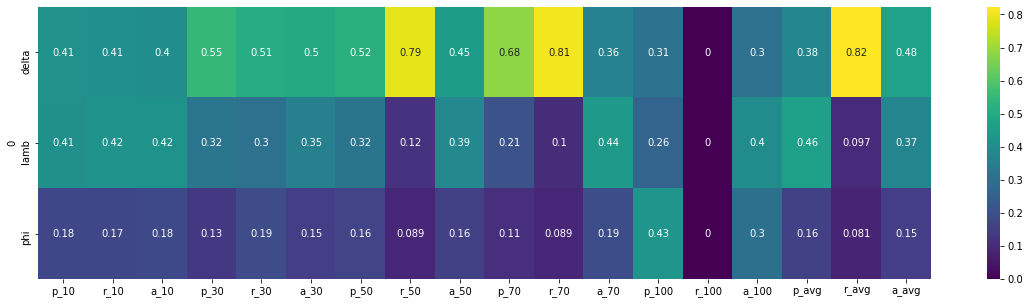

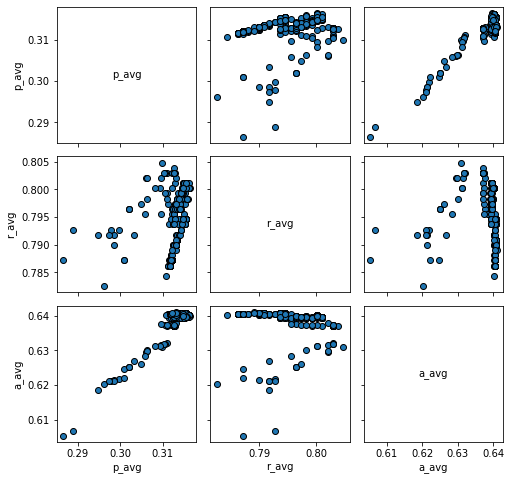

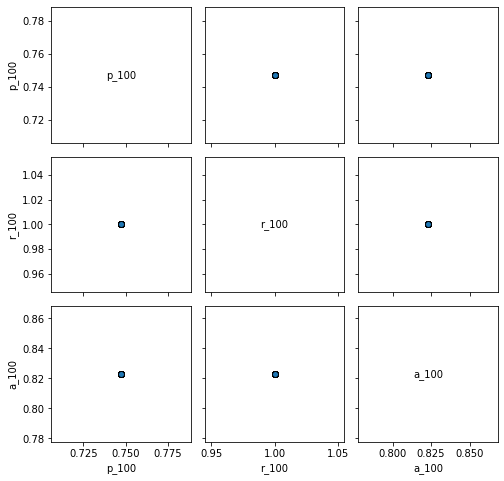

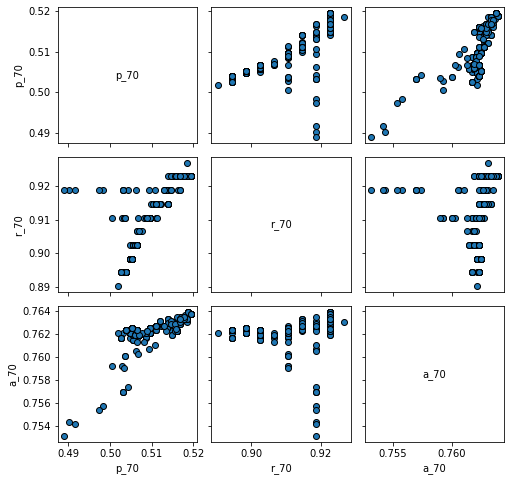

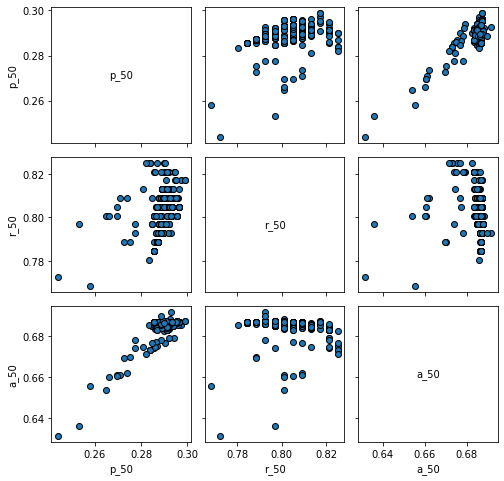

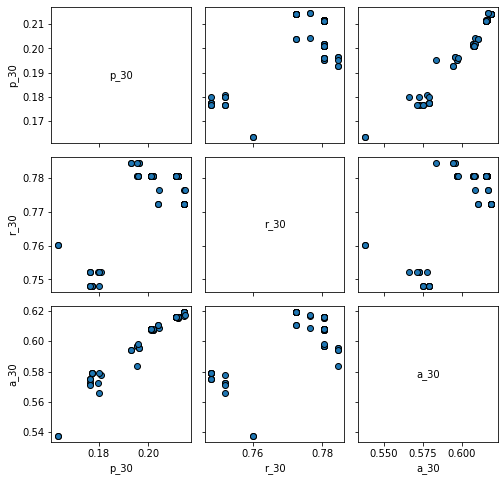

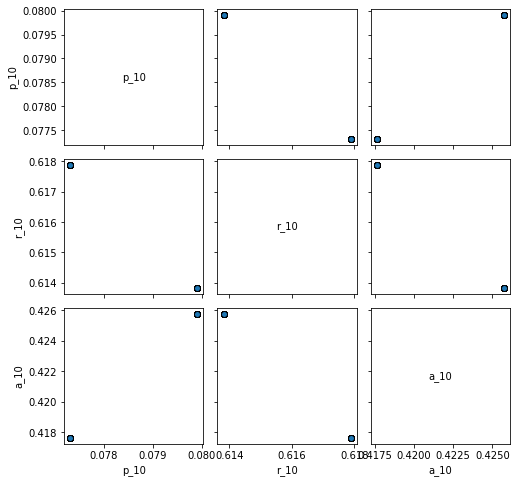

In [4]:
# blocks-world
results = load_results('./sa/1000_scenarios_blocks-world.tar.gz')

show_feature_score(results)
show_points(results, "avg")
show_points(results, "100")
show_points(results, "70")
show_points(results, "50")
show_points(results, "30")
show_points(results, "10")

### SOBOL Sampling

In [5]:
# the first order and total:

from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

def show_effects(sa_results, outcomes_field):
    experiments, outcomes = sa_results
    problem = get_SALib_problem(model.uncertainties)
    Si = sobol.analyze(problem, outcomes[outcomes_field],
                       calc_second_order=True, print_to_console=False)

    scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()

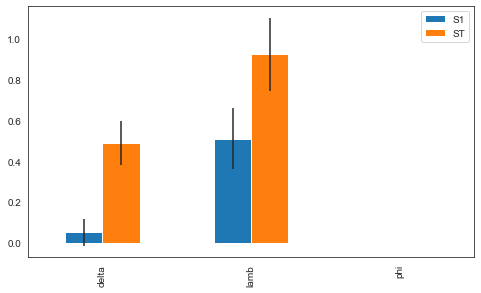

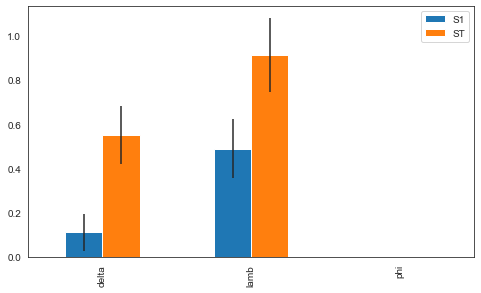

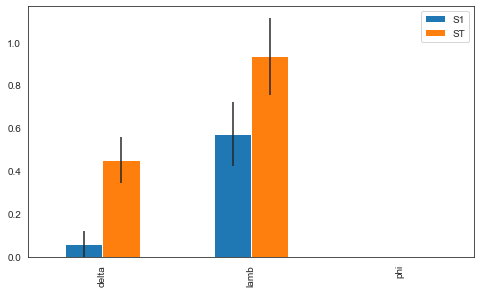

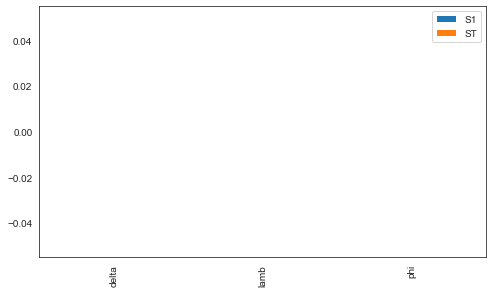

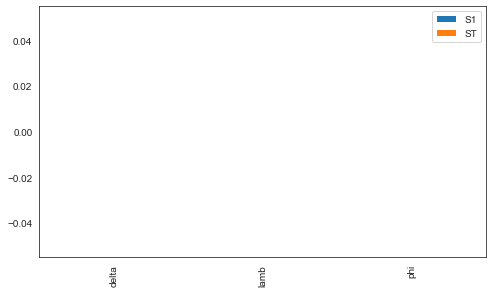

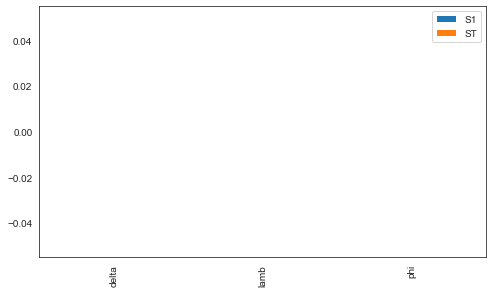

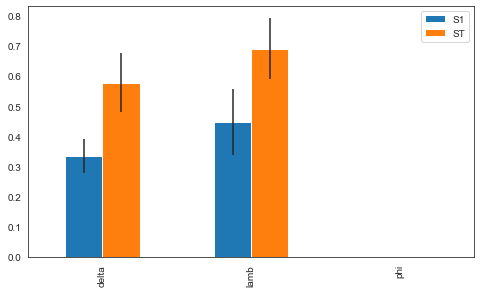

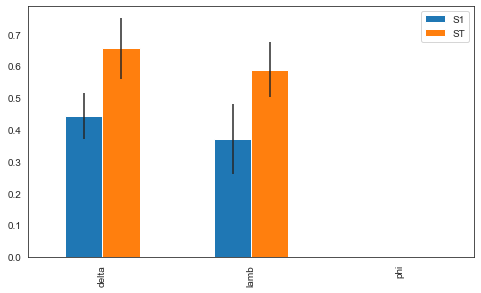

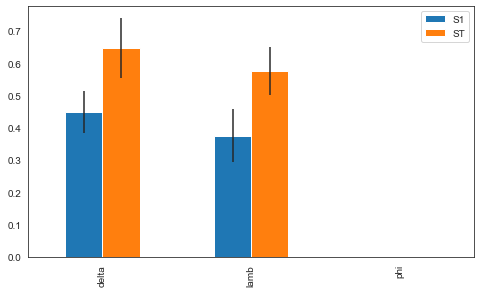

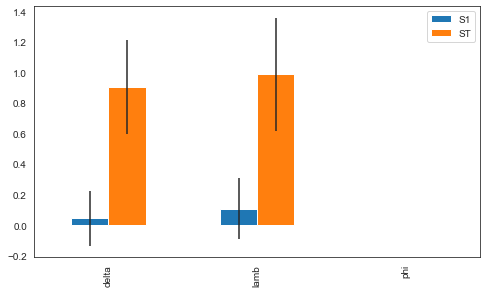

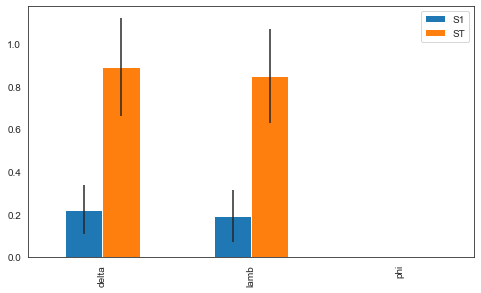

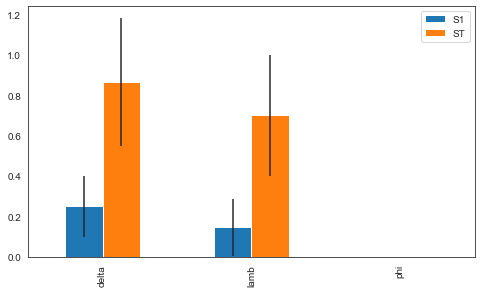

In [10]:
sa_results = load_results('./sa/1050_scenarios_ferry_sobol.tar.gz')
show_effects(sa_results, 'a_avg')
show_effects(sa_results, 'r_avg')
show_effects(sa_results, 'p_avg')

show_effects(sa_results, 'a_100')
show_effects(sa_results, 'r_100')
show_effects(sa_results, 'p_100')

show_effects(sa_results, 'a_70')
show_effects(sa_results, 'r_70')
show_effects(sa_results, 'p_70')

show_effects(sa_results, 'a_10')
show_effects(sa_results, 'r_10')
show_effects(sa_results, 'p_10')